# 12장. k 최근접 이웃 (kNN)

## 1. k-NN 분류기

### 투표 함수

In [1]:
from typing import List
from collections import Counter

#### 최대 득표 방식으로 투표를 실시

In [2]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

#### 동률이 발생하면 k를 하나씩 줄이면서 재투표

In [3]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

### k-NN 분류기

#### 데이터 포인트 자료 구조

In [4]:
from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

In [5]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str

#### k-NN 분류기

In [6]:
def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

## 2. (key, value) 자료 구조

#### 1안. Collections의 namedtuple 이용하기

In [7]:
import datetime
from collections import namedtuple

StockPrice1 = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice1('MSFT', datetime.date(2018, 12, 14), 106.03)

#### 2안. Typing의 NamedTuple 이용하기

In [8]:
from typing import NamedTuple
class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

#### 3안. dataclasses의 dataclass 이용하기

In [9]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)
assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## 3. k-NN 예시 (붓꽃 종 분류)

### 데이터셋 다운로드

In [10]:
import requests

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open("iris.data", "w") as f:
  f.write(data.text)

### 데이터 읽기

In [11]:
from typing import Dict
import csv
from collections import defaultdict

#### 데이터 파싱

In [12]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

#### csv 파일 읽기

In [13]:
with open("iris.data") as f:
    reader = csv.reader(f)
    # for i, row in enumerate(reader):
    #    print(i, row)
    iris_data = [parse_iris_row(row) for row in reader if row]
    # print(iris_data)

#### 붓꽃 종 별 딕셔너리 생성

In [14]:
# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)
# print(points_by_species)

### 데이터 탐색

In [15]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
print(pairs)
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


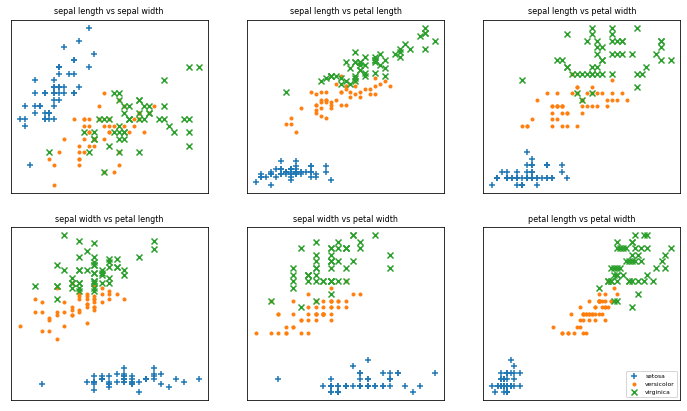

In [16]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(30, 20))
fig, ax = plt.subplots(2, 3, figsize=(12, 7))

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

### 데이터셋 분리

In [17]:
import random
from scratch.machine_learning import split_data

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

### 예측 

In [18]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## 4. 차원의 저주

In [19]:
import random

def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

In [20]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

min_avg_ratio = [min_dist / avg_dist
                    for min_dist, avg_dist in zip(min_distances, avg_distances)]

Curse of Dimensionality: 100%|███████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


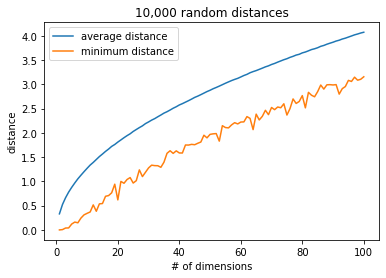

In [21]:
   from matplotlib import pyplot as plt

   plt.plot(dimensions, avg_distances)
   plt.plot(dimensions, min_distances)
   plt.title("10,000 random distances")
   plt.legend(["average distance", "minimum distance"], loc='upper left')
   plt.xlabel("# of dimensions")
   plt.ylabel("distance")

   plt.show()

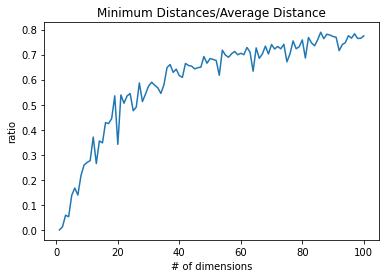

In [22]:
   from matplotlib import pyplot as plt

   plt.plot(dimensions, min_avg_ratio)
   plt.title("Minimum Distances/Average Distance")
   plt.xlabel("# of dimensions")
   plt.ylabel("ratio")

   plt.show()

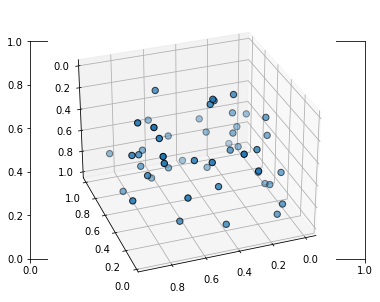

In [23]:
from mpl_toolkits.mplot3d import Axes3D

dim = 3
num_pairs = 50

points = [random_point(dim) for _ in range(num_pairs)]
x_coord, y_coord, z_coord = zip(*points)

fig, ax = plt.subplots(1, 1)
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(x_coord, y_coord, z_coord,
           cmap=plt.cm.Set1, edgecolor='k', s=40)